# Deliverable 2.3: Baseline Model with Results


**Group 16**

Sarim Malik (26100129), Muhammad Nafees (26100029)

**Note:** non-IID partitioning framework and evaluation metrics shall be kept constant across all the baseline model development.


# Knowledge Carrier: Parameter Based

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import matplotlib.pyplot as plt
from collections import Counter
import copy
import random
from typing import Dict, List, Tuple

# random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.01
NUM_EPOCHS = 5
NUM_COMMUNICATION_ROUNDS = 5
BASE_TEMPERATURE = 3.0  # Base distillation temperature
BETA = 2.0  # Temperature scaling factor
ALPHA = 0.1  # Dirichlet distribution concentration parameter (lower = more skewed)
CLIENT_FRACTION = 1.0  # Fraction of clients to select per round (1.0 = all clients)
KD_ALPHA = 0.5  # Weight for KD loss (balance between CE and KD)

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
    
    def get_features(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        return x

In [7]:
def load_and_partition_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    #  seeds for data partitioning
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    
    full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    
    n_total = len(full_dataset)
    n_server_val = int(0.1 * n_total)  # 10% for server validation
    n_client_data = n_total - n_server_val  # 90% for clients
    
    g = torch.Generator().manual_seed(42)
    client_data, server_val_data = random_split(full_dataset, [n_client_data, n_server_val], generator=g)
    
    client_indices = client_data.indices
    all_targets = np.array(full_dataset.targets)
    labels = all_targets[client_indices]
    
    num_classes = 10
    num_clients = 2
    
    np.random.seed(42)
    client_label_distribution = np.random.dirichlet(np.repeat(ALPHA, num_clients), size=num_classes)
    
    class_indices = [np.where(labels == class_idx)[0] for class_idx in range(num_classes)]
    
    client_indices = [[] for _ in range(num_clients)]
    
    for class_idx, distribution in enumerate(client_label_distribution):
        class_size = len(class_indices[class_idx])
        num_samples_per_client = (distribution * class_size).astype(int) 
        samples_assigned = 0
        
        for client_idx, num_samples in enumerate(num_samples_per_client):
            if client_idx == num_clients - 1:
                num_samples = class_size - samples_assigned
                
            if num_samples > 0:
                selected_indices = class_indices[class_idx][samples_assigned:samples_assigned+num_samples]
                client_indices[client_idx].extend(selected_indices)
                samples_assigned += num_samples
    
    client_datasets = []
    client_train_loaders = []
    client_val_loaders = []
    client_class_distributions = []
    
    for client_idx, indices in enumerate(client_indices):
        np.random.seed(42 + client_idx)
        np.random.shuffle(indices)
        
        client_labels = [labels[i] for i in indices]
        class_counts = Counter(client_labels)
        distribution = {cls: count/len(client_labels) for cls, count in class_counts.items()}
        client_class_distributions.append(distribution)
        
        n_train = int(0.8 * len(indices))
        train_indices = indices[:n_train]
        val_indices = indices[n_train:]
        
        train_indices_original = [client_data.indices[i] for i in train_indices]
        val_indices_original = [client_data.indices[i] for i in val_indices]
        
        client_train_dataset = Subset(full_dataset, train_indices_original)
        client_val_dataset = Subset(full_dataset, val_indices_original)
        
        g_train = torch.Generator().manual_seed(42 + client_idx)
        g_val = torch.Generator().manual_seed(42 + client_idx + num_clients)
        
        train_loader = DataLoader(client_train_dataset, batch_size=BATCH_SIZE, 
                                  shuffle=True, generator=g_train)
        val_loader = DataLoader(client_val_dataset, batch_size=BATCH_SIZE, 
                                generator=g_val)
        
        client_datasets.append((client_train_dataset, client_val_dataset))
        client_train_loaders.append(train_loader)
        client_val_loaders.append(val_loader)
    
    g_server = torch.Generator().manual_seed(42 + 2*num_clients)
    g_test = torch.Generator().manual_seed(42 + 2*num_clients + 1)
    
    server_val_loader = DataLoader(server_val_data, batch_size=BATCH_SIZE, generator=g_server)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, generator=g_test)
    
    print("Data partitioning complete.")
    for i, dist in enumerate(client_class_distributions):
        print(f"Client {i} class distribution:")
        for cls in range(10):
            print(f"  Class {cls}: {dist.get(cls, 0):.2f}")
    
    # reset random seeds 
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    
    return client_train_loaders, client_val_loaders, server_val_loader, test_loader, client_class_distributions

In [6]:
def generate_partition_statistics(client_train_loaders, client_val_loaders, server_val_loader, test_loader):
    
    statistics = {
        "clients": [],
        "server_val": {},
        "test": {}
    }
    
    def extract_labels(loader):
        all_labels = []
        for _, labels in loader:
            all_labels.extend(labels.numpy())
        return np.array(all_labels)
    
    for i, (train_loader, val_loader) in enumerate(zip(client_train_loaders, client_val_loaders)):
        client_stats = {
            "id": i,
            "train": {},
            "validation": {}
        }
        
        train_labels = extract_labels(train_loader)
        train_counts = Counter(train_labels)
        total_train = len(train_labels)
        
        client_stats["train"]["sample_count"] = total_train
        client_stats["train"]["class_counts"] = {k: v for k, v in sorted(train_counts.items())}
        client_stats["train"]["class_percentages"] = {k: 100*v/total_train for k, v in sorted(train_counts.items())}
        client_stats["train"]["avg_samples_per_class"] = total_train / len(set(train_labels))
        
        val_labels = extract_labels(val_loader)
        val_counts = Counter(val_labels)
        total_val = len(val_labels)
        
        client_stats["validation"]["sample_count"] = total_val
        client_stats["validation"]["class_counts"] = {k: v for k, v in sorted(val_counts.items())}
        client_stats["validation"]["class_percentages"] = {k: 100*v/total_val for k, v in sorted(val_counts.items())}
        client_stats["validation"]["avg_samples_per_class"] = total_val / len(set(val_labels))
        
        statistics["clients"].append(client_stats)
    
    server_val_labels = extract_labels(server_val_loader)
    server_val_counts = Counter(server_val_labels)
    total_server_val = len(server_val_labels)
    
    statistics["server_val"]["sample_count"] = total_server_val
    statistics["server_val"]["class_counts"] = {k: v for k, v in sorted(server_val_counts.items())}
    statistics["server_val"]["class_percentages"] = {k: 100*v/total_server_val for k, v in sorted(server_val_counts.items())}
    statistics["server_val"]["avg_samples_per_class"] = total_server_val / len(set(server_val_labels))
    
    
    test_labels = extract_labels(test_loader)
    test_counts = Counter(test_labels)
    total_test = len(test_labels)
    
    statistics["test"]["sample_count"] = total_test
    statistics["test"]["class_counts"] = {k: v for k, v in sorted(test_counts.items())}
    statistics["test"]["class_percentages"] = {k: 100*v/total_test for k, v in sorted(test_counts.items())}
    statistics["test"]["avg_samples_per_class"] = total_test / len(set(test_labels))
    
    return statistics

def print_partition_statistics(statistics):
    
    print("=" * 80)
    print(f"PARTITION STATISTICS")
    print("=" * 80)
    
    for client in statistics["clients"]:
        client_id = client["id"]
        print(f"\n{'=' * 20} CLIENT {client_id} {'=' * 20}")
        
        # Training set
        train_stats = client["train"]
        print(f"\n--- TRAINING SET ---")
        print(f"Number of samples: {train_stats['sample_count']}")
        print(f"Average samples per class: {train_stats['avg_samples_per_class']:.2f}")
        print("\nClass distribution:")
        for cls, count in train_stats["class_counts"].items():
            percentage = train_stats["class_percentages"][cls]
            print(f"  Class {cls}: {count} samples ({percentage:.2f}%)")
        
        # Validation set
        val_stats = client["validation"]
        print(f"\n--- VALIDATION SET ---")
        print(f"Number of samples: {val_stats['sample_count']}")
        print(f"Average samples per class: {val_stats['avg_samples_per_class']:.2f}")
        print("\nClass distribution:")
        for cls, count in val_stats["class_counts"].items():
            percentage = val_stats["class_percentages"][cls]
            print(f"  Class {cls}: {count} samples ({percentage:.2f}%)")
    
    print(f"\n{'=' * 20} SERVER VALIDATION {'=' * 20}")
    server_val_stats = statistics["server_val"]
    print(f"Number of samples: {server_val_stats['sample_count']}")
    print(f"Average samples per class: {server_val_stats['avg_samples_per_class']:.2f}")
    print("\nClass distribution:")
    for cls, count in server_val_stats["class_counts"].items():
        percentage = server_val_stats["class_percentages"][cls]
        print(f"  Class {cls}: {count} samples ({percentage:.2f}%)")
    
    print(f"\n{'=' * 20} TEST SET {'=' * 20}")
    test_stats = statistics["test"]
    print(f"Number of samples: {test_stats['sample_count']}")
    print(f"Average samples per class: {test_stats['avg_samples_per_class']:.2f}")
    print("\nClass distribution:")
    for cls, count in test_stats["class_counts"].items():
        percentage = test_stats["class_percentages"][cls]
        print(f"  Class {cls}: {count} samples ({percentage:.2f}%)")
        
    print("\n" + "=" * 80)

def generate_stats():
    client_train_loaders, client_val_loaders, server_val_loader, test_loader, client_class_distributions = load_and_partition_data()
    
    statistics = generate_partition_statistics(client_train_loaders, client_val_loaders, server_val_loader, test_loader)
    print_partition_statistics(statistics)
    

In [7]:
generate_stats()

Files already downloaded and verified
Files already downloaded and verified
Data partitioning complete.
Client 0 class distribution:
  Class 0: 0.00
  Class 1: 0.18
  Class 2: 0.18
  Class 3: 0.18
  Class 4: 0.01
  Class 5: 0.18
  Class 6: 0.18
  Class 7: 0.08
  Class 8: 0.00
  Class 9: 0.00
Client 1 class distribution:
  Class 0: 0.22
  Class 1: 0.00
  Class 2: 0.00
  Class 3: 0.00
  Class 4: 0.22
  Class 5: 0.00
  Class 6: 0.00
  Class 7: 0.12
  Class 8: 0.22
  Class 9: 0.22
PARTITION STATISTICS

==================== CLIENT 0 ====================

--- TRAINING SET ---
Number of samples: 19648
Average samples per class: 2183.11

Class distribution:
  Class 0: 5 samples (0.03%)
  Class 1: 3613 samples (18.39%)
  Class 2: 3592 samples (18.28%)
  Class 3: 3621 samples (18.43%)
  Class 4: 107 samples (0.54%)
  Class 5: 3621 samples (18.43%)
  Class 6: 3571 samples (18.17%)
  Class 7: 1517 samples (7.72%)
  Class 9: 1 samples (0.01%)

--- VALIDATION SET ---
Number of samples: 4913
Average 

In [9]:
def distillation_loss(outputs, teacher_outputs, temperature, labels=None, alpha=KD_ALPHA):
    """
    Compute the knowledge distillation loss.
    
    Args:
        outputs: Student model outputs
        teacher_outputs: Teacher model outputs
        temperature: Temperature for softening probability distributions
        labels: True labels (optional, for hard loss component)
        alpha: Weight for balancing soft and hard losses (0-1)
        
    Returns:
        Combined KD loss
    """
    if labels is not None:
        hard_loss = F.cross_entropy(outputs, labels)
        
        soft_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(outputs / temperature, dim=1),
            F.softmax(teacher_outputs / temperature, dim=1)
        ) * (temperature ** 2)
        
        return alpha * soft_loss + (1 - alpha) * hard_loss
    else:
        return nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(outputs / temperature, dim=1),
            F.softmax(teacher_outputs / temperature, dim=1)
        ) * (temperature ** 2)

def train_client(model, local_train_loader, local_val_loader, global_model, optimizer, epochs, temperature):
    
    model.train()
    global_model.eval()  
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        total_samples = 0
        
        for images, labels in local_train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            
            with torch.no_grad():
                teacher_outputs = global_model(images)
            
            loss = distillation_loss(outputs, teacher_outputs, temperature, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            total_samples += images.size(0)
        
        epoch_loss = running_loss / total_samples
        train_losses.append(epoch_loss)
        
        val_loss, val_acc = evaluate(model, local_val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    return model, train_losses, val_losses, val_accuracies

def train_global(global_model, client_models, server_val_loader, optimizer, temperature):
    """
    Train global model with KD from client models
    """
    global_model.train()
    for client_model in client_models:
        client_model.eval() 
    
    running_loss = 0.0
    total_samples = 0
    
    for images, labels in server_val_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass through global model
        global_outputs = global_model(images)
        
        combined_loss = 0.0
        
        for client_model in client_models:
            # get teacher predictions from client model
            with torch.no_grad():
                client_outputs = client_model(images)
            
            # add KD loss from this client
            client_loss = distillation_loss(global_outputs, client_outputs, temperature)
            combined_loss += client_loss
        
        # average the KD losses from all clients
        combined_loss /= len(client_models)
        
        # add cross-entropy loss with true labels
        ce_loss = F.cross_entropy(global_outputs, labels)
        
        # final loss is a combination of CE and KD losses
        loss = (1 - KD_ALPHA) * ce_loss + KD_ALPHA * combined_loss
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        total_samples += images.size(0)
    
    return global_model, running_loss / total_samples

def evaluate(model, data_loader):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / total
    accuracy = correct / total
    
    return avg_loss, accuracy

# FedAvg function to aggregate client models
def federated_averaging(global_model, client_models, client_sample_sizes):
    """
    Args:
        global_model: The global model to be updated
        client_models: List of client models
        client_sample_sizes: List of number of samples per client
    
    Returns:
        Updated global model
    """
    global_params = global_model.state_dict()
    
    total_samples = sum(client_sample_sizes)
    
    weighted_params = {name: torch.zeros_like(param) for name, param in global_params.items()}
    
    for client_idx, client_model in enumerate(client_models):
        client_params = client_model.state_dict()
        weight = client_sample_sizes[client_idx] / total_samples
        
        for name, param in client_params.items():
            weighted_params[name] += param * weight
    
    global_model.load_state_dict(weighted_params)
    
    return global_model

In [10]:
def train_bidirectional_fedkd():

    client_train_loaders, client_val_loaders, server_val_loader, test_loader, client_distributions = load_and_partition_data()
    
    num_clients = len(client_train_loaders)
    print(f"Setting up bidirectional FedKD with {num_clients} clients")
    
    global_model = SimpleCNN().to(device)
    global_optimizer = optim.SGD(global_model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    
    global_val_losses = []
    global_val_accuracies = []
    global_test_accuracies = []
    
    clients_val_accuracies = [[] for _ in range(num_clients)]
    clients_test_accuracies = [[] for _ in range(num_clients)]
    
    client_models = []
    client_optimizers = []
    
    for i in range(num_clients):
        client_model = SimpleCNN().to(device)
        client_model.load_state_dict(copy.deepcopy(global_model.state_dict()))
        client_optimizer = optim.SGD(client_model.parameters(), lr=LEARNING_RATE, momentum=0.9)
        
        client_models.append(client_model)
        client_optimizers.append(client_optimizer)
    
    for comm_round in range(NUM_COMMUNICATION_ROUNDS):
        print(f"\n--- Communication Round {comm_round+1}/{NUM_COMMUNICATION_ROUNDS} ---")
        
        num_selected = max(1, int(CLIENT_FRACTION * num_clients))
        selected_clients = np.random.choice(range(num_clients), num_selected, replace=False)
        
        print(f"Selected clients: {selected_clients}")
        
        temperature = BASE_TEMPERATURE #* (BETA ** comm_round)
        print(f"Using temperature: {temperature:.2f}")
        
        updated_client_models = []
        client_sample_sizes = []
        
        # Step 1: client Update with KD from global to clients // train client with KD from global model
        for idx in selected_clients:
            print(f"\nTraining Client {idx}")
            client_model = client_models[idx]
            train_loader = client_train_loaders[idx]
            val_loader = client_val_loaders[idx]
            optimizer = client_optimizers[idx]
            
            # training here
            updated_model, _, _, _ = train_client(
                client_model, 
                train_loader, 
                val_loader, 
                global_model, 
                optimizer, 
                NUM_EPOCHS,
                temperature
            )
            
            updated_client_models.append(updated_model)
            client_sample_sizes.append(len(train_loader.dataset))
            
        # Step 2: FedAvg - Aggregate client models to update global model
        print("\nAggregating client models with FedAvg")
        global_model = federated_averaging(global_model, updated_client_models, client_sample_sizes)
        
        # Step 3: Server Update with reverse KD from clients to global
        print("\nUpdating global model with reverse KD from clients")
        global_model, global_train_loss = train_global(
            global_model, 
            updated_client_models, 
            server_val_loader, 
            global_optimizer,
            temperature
        )
        
        # evaluate global model on server val & test set
        global_val_loss, global_val_acc = evaluate(global_model, server_val_loader)
        global_test_loss, global_test_acc = evaluate(global_model, test_loader)
        
        global_val_losses.append(global_val_loss)
        global_val_accuracies.append(global_val_acc)
        global_test_accuracies.append(global_test_acc)
        
        print(f"\nGlobal Model - Val Loss: {global_val_loss:.4f}, Val Acc: {global_val_acc:.4f}")
        print(f"Global Model - Test Loss: {global_test_loss:.4f}, Test Acc: {global_test_acc:.4f}")
        
        # update client models with new global model for next round (for non-selected clients)
        for idx in range(num_clients):
            if idx not in selected_clients:
                client_models[idx].load_state_dict(copy.deepcopy(global_model.state_dict()))
        
        # FOR ME:  vvaluate each client model on server val & test set
        print("\nEvaluating client models on server datasets:")
        for idx, client_model in enumerate(client_models):
            client_val_loss, client_val_acc = evaluate(client_model, server_val_loader)
            client_test_loss, client_test_acc = evaluate(client_model, test_loader)
            
            clients_val_accuracies[idx].append(client_val_acc)
            clients_test_accuracies[idx].append(client_test_acc)
            
            print(f"Client {idx} - Server Val Acc: {client_val_acc:.4f}, Test Acc: {client_test_acc:.4f}")
    
    # final evaluation
    final_test_loss, final_test_acc = evaluate(global_model, test_loader)
    print(f"\nFinal Global Model Test Accuracy: {final_test_acc:.4f}")
    
    print("\nFinal Client Generalization Performance:")
    for i in range(len(client_models)):
        print(f"Client {i} - Final Server Val Acc: {clients_val_accuracies[i][-1]:.4f}, Final Test Acc: {clients_test_accuracies[i][-1]:.4f}")
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(range(1, NUM_COMMUNICATION_ROUNDS+1), global_val_accuracies, 'b-', label='Global Val Acc')
    plt.plot(range(1, NUM_COMMUNICATION_ROUNDS+1), global_test_accuracies, 'r-', label='Global Test Acc')
    plt.title('Global Model Performance')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    for i in range(num_clients):
        plt.plot(range(1, NUM_COMMUNICATION_ROUNDS+1), clients_val_accuracies[i], '--', label=f'Client {i} Val Acc')
        plt.plot(range(1, NUM_COMMUNICATION_ROUNDS+1), clients_test_accuracies[i], ':', label=f'Client {i} Test Acc')
    plt.title('Client Models Generalization')
    plt.xlabel('Communication Round')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return global_model, client_models, global_val_losses, global_val_accuracies, global_test_accuracies, clients_val_accuracies, clients_test_accuracies

In [11]:
# Standard client training for FedAvg (no KD)
def train_client_fedavg(model, local_train_loader, local_val_loader, optimizer, epochs):
    """
    Train client model using standard cross-entropy loss (pure FedAvg)
    """
    model.train()
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        total_samples = 0
        
        for images, labels in local_train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass through client model
            outputs = model(images)
            
            # Standard cross-entropy loss (no KD)
            loss = F.cross_entropy(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            total_samples += images.size(0)
        
        epoch_loss = running_loss / total_samples
        train_losses.append(epoch_loss)
        
        # Validation
        val_loss, val_acc = evaluate(model, local_val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    return model, train_losses, val_losses, val_accuracies

# Main FedAvg training loop
def train_fedavg():
    # Load and partition data
    client_train_loaders, client_val_loaders, server_val_loader, test_loader, client_distributions = load_and_partition_data()
    
    num_clients = len(client_train_loaders)
    print(f"Setting up FedAvg with {num_clients} clients")
    
    # Initialize global model
    global_model = SimpleCNN().to(device)
    
    # Track global model performance
    global_val_losses = []
    global_val_accuracies = []
    global_test_accuracies = []
    
    # Track client performance on server validation and test sets
    clients_val_accuracies = [[] for _ in range(num_clients)]
    clients_test_accuracies = [[] for _ in range(num_clients)]
    
    # Initialize client models with global model parameters
    client_models = []
    client_optimizers = []
    
    for i in range(num_clients):
        client_model = SimpleCNN().to(device)
        client_model.load_state_dict(copy.deepcopy(global_model.state_dict()))
        client_optimizer = optim.SGD(client_model.parameters(), lr=LEARNING_RATE, momentum=0.9)
        
        client_models.append(client_model)
        client_optimizers.append(client_optimizer)
    
    # Main training loop
    for comm_round in range(NUM_COMMUNICATION_ROUNDS):
        print(f"\n--- Communication Round {comm_round+1}/{NUM_COMMUNICATION_ROUNDS} ---")
        
        # Select clients for this round (using fraction)
        num_selected = max(1, int(CLIENT_FRACTION * num_clients))
        selected_clients = np.random.choice(range(num_clients), num_selected, replace=False)
        
        print(f"Selected clients: {selected_clients}")
        
        # Store updated client models and their sample sizes
        updated_client_models = []
        client_sample_sizes = []
        
        # Step 1: Client Update (standard training, no KD)
        for idx in selected_clients:
            print(f"\nTraining Client {idx}")
            client_model = client_models[idx]
            train_loader = client_train_loaders[idx]
            val_loader = client_val_loaders[idx]
            optimizer = client_optimizers[idx]
            
            # Train client with standard cross-entropy loss
            updated_model, _, _, _ = train_client_fedavg(
                client_model, 
                train_loader, 
                val_loader, 
                optimizer, 
                NUM_EPOCHS
            )
            
            # Save updated client model
            updated_client_models.append(updated_model)
            client_sample_sizes.append(len(train_loader.dataset))
            
        # Step 2: FedAvg - Aggregate client models to update global model
        print("\nAggregating client models with FedAvg")
        global_model = federated_averaging(global_model, updated_client_models, client_sample_sizes)
        
        # Evaluate global model on server validation and test sets
        global_val_loss, global_val_acc = evaluate(global_model, server_val_loader)
        global_test_loss, global_test_acc = evaluate(global_model, test_loader)
        
        global_val_losses.append(global_val_loss)
        global_val_accuracies.append(global_val_acc)
        global_test_accuracies.append(global_test_acc)
        
        print(f"\nGlobal Model - Val Loss: {global_val_loss:.4f}, Val Acc: {global_val_acc:.4f}")
        print(f"Global Model - Test Loss: {global_test_loss:.4f}, Test Acc: {global_test_acc:.4f}")
        
        # Update client models with new global model for next round
        for idx in range(num_clients):
            if idx not in selected_clients:
                client_models[idx].load_state_dict(copy.deepcopy(global_model.state_dict()))
        
        # Evaluate each client model on server validation and test sets
        print("\nEvaluating client models on server datasets:")
        for idx, client_model in enumerate(client_models):
            client_val_loss, client_val_acc = evaluate(client_model, server_val_loader)
            client_test_loss, client_test_acc = evaluate(client_model, test_loader)
            
            clients_val_accuracies[idx].append(client_val_acc)
            clients_test_accuracies[idx].append(client_test_acc)
            
            print(f"Client {idx} - Server Val Acc: {client_val_acc:.4f}, Test Acc: {client_test_acc:.4f}")
    
    # Final evaluation
    final_test_loss, final_test_acc = evaluate(global_model, test_loader)
    print(f"\nFinal Global Model Test Accuracy: {final_test_acc:.4f}")
    
    # Print final client performances
    print("\nFinal Client Generalization Performance:")
    for i in range(len(client_models)):
        print(f"Client {i} - Final Server Val Acc: {clients_val_accuracies[i][-1]:.4f}, Final Test Acc: {clients_test_accuracies[i][-1]:.4f}")
    
    # Plot training progress
    plt.figure(figsize=(12, 8))
    
    # Global model performance
    plt.subplot(2, 1, 1)
    plt.plot(range(1, NUM_COMMUNICATION_ROUNDS+1), global_val_accuracies, 'b-', label='Global Val Acc')
    plt.plot(range(1, NUM_COMMUNICATION_ROUNDS+1), global_test_accuracies, 'r-', label='Global Test Acc')
    plt.title('FedAvg Global Model Performance')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Client generalization performance
    plt.subplot(2, 1, 2)
    for i in range(num_clients):
        plt.plot(range(1, NUM_COMMUNICATION_ROUNDS+1), clients_val_accuracies[i], '--', label=f'Client {i} Val Acc')
        plt.plot(range(1, NUM_COMMUNICATION_ROUNDS+1), clients_test_accuracies[i], ':', label=f'Client {i} Test Acc')
    plt.title('FedAvg Client Models Generalization')
    plt.xlabel('Communication Round')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return global_model, client_models, global_val_losses, global_val_accuracies, global_test_accuracies, clients_val_accuracies, clients_test_accuracies

1. **Standard FedAvg**

   **FedAvg** remains the foundational benchmark in federated learning research due to its simplicity and effectiveness in aggregating decentralized models. Although it performs parameter averaging and assumes identical model architectures across clients, it provides a solid baseline to measure how much performance gain is achieved by more complex or specialized approaches. 

100%|██████████| 170M/170M [00:01<00:00, 85.8MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Data partitioning complete.
Client 0 class distribution:
  Class 0: 0.00
  Class 1: 0.18
  Class 2: 0.18
  Class 3: 0.18
  Class 4: 0.01
  Class 5: 0.18
  Class 6: 0.18
  Class 7: 0.08
  Class 8: 0.00
  Class 9: 0.00
Client 1 class distribution:
  Class 0: 0.22
  Class 1: 0.00
  Class 2: 0.00
  Class 3: 0.00
  Class 4: 0.22
  Class 5: 0.00
  Class 6: 0.00
  Class 7: 0.12
  Class 8: 0.22
  Class 9: 0.22
Setting up FedAvg with 2 clients

--- Communication Round 1/5 ---
Selected clients: [1 0]

Training Client 1
Epoch 1/5, Train Loss: 1.3120, Val Loss: 0.9854, Val Acc: 0.6023
Epoch 2/5, Train Loss: 0.8689, Val Loss: 0.8219, Val Acc: 0.6844
Epoch 3/5, Train Loss: 0.7016, Val Loss: 0.6320, Val Acc: 0.7615
Epoch 4/5, Train Loss: 0.5754, Val Loss: 0.5906, Val Acc: 0.7801
Epoch 5/5, Train Loss: 0.4880, Val Loss: 0.5039, Val Acc: 0.8185

Training Client 0
Epoch 1/5, Train Loss: 1.5924, Val Loss: 1.2092, Val

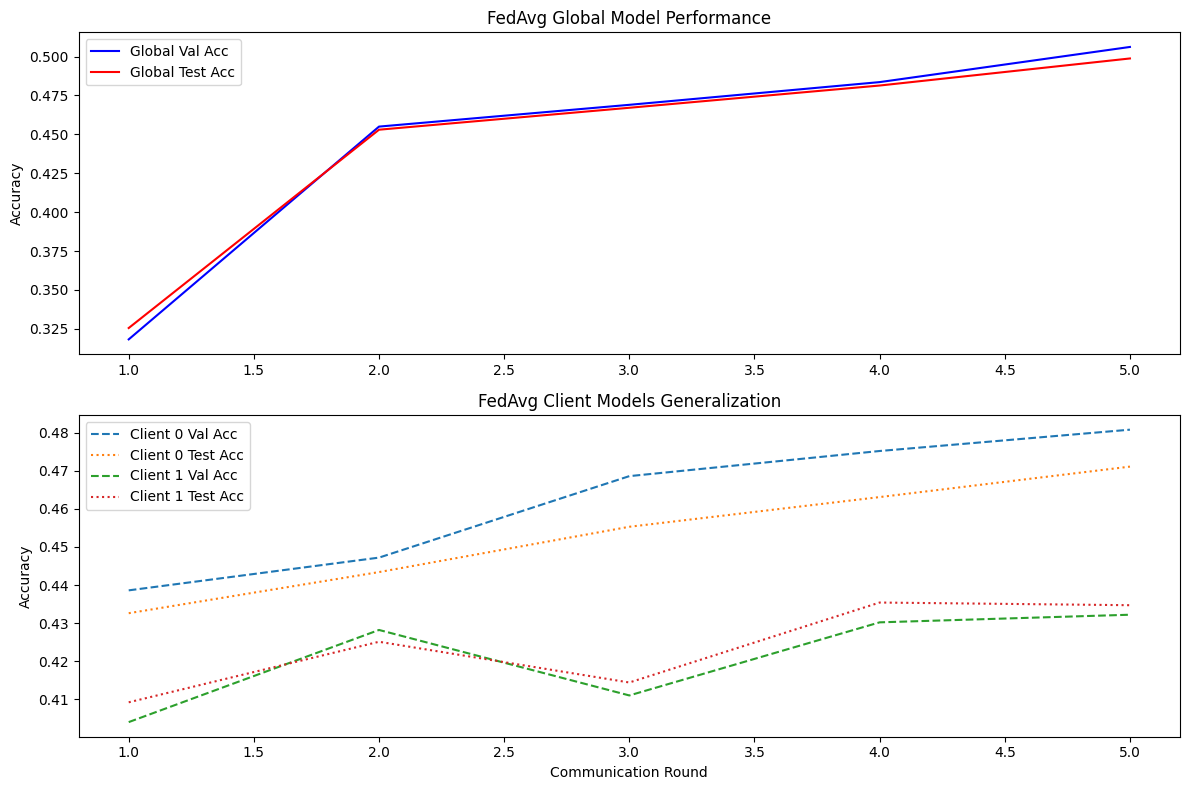

Training complete!


In [12]:
if __name__ == "__main__":
    global_model, client_models, val_losses, val_accuracies, test_accuracies, clients_val_accuracies, clients_test_accuracies = train_fedavg()
    print("Training complete!")


2. **bidirectional KD using FedAvg approach**

   Individual clients in bidirectional FedKD show higher accuracy on the server validation and test sets compared to standard FedAvg. The knowledge distillation from clients to global model helps the global model learn specialized knowledge from different data distributions. Individual clients in bidirectional FedKD also show higher accuracy on the server validation and test sets compared to standard FedAvg. Additionally, as the non-IID degree increases (alpha decreases), the performance gap between FedKD and FedAvg should widen. Hence this will be a more robust baseline to test our novel pipeline against. So we have also implemented this approach and chosen to include it as one of our baseline models.

Files already downloaded and verified
Files already downloaded and verified
Data partitioning complete.
Client 0 class distribution:
  Class 0: 0.00
  Class 1: 0.18
  Class 2: 0.18
  Class 3: 0.18
  Class 4: 0.01
  Class 5: 0.18
  Class 6: 0.18
  Class 7: 0.08
  Class 8: 0.00
  Class 9: 0.00
Client 1 class distribution:
  Class 0: 0.22
  Class 1: 0.00
  Class 2: 0.00
  Class 3: 0.00
  Class 4: 0.22
  Class 5: 0.00
  Class 6: 0.00
  Class 7: 0.12
  Class 8: 0.22
  Class 9: 0.22
Setting up bidirectional FedKD with 2 clients

--- Communication Round 1/5 ---
Selected clients: [1 0]
Using temperature: 3.00

Training Client 1
Epoch 1/5, Train Loss: 0.9495, Val Loss: 1.4760, Val Acc: 0.5594
Epoch 2/5, Train Loss: 0.8148, Val Loss: 1.3044, Val Acc: 0.6323
Epoch 3/5, Train Loss: 0.7662, Val Loss: 1.2074, Val Acc: 0.6920
Epoch 4/5, Train Loss: 0.7300, Val Loss: 1.1224, Val Acc: 0.7011
Epoch 5/5, Train Loss: 0.7037, Val Loss: 1.0576, Val Acc: 0.7468

Training Client 0
Epoch 1/5, Train Loss: 1.025

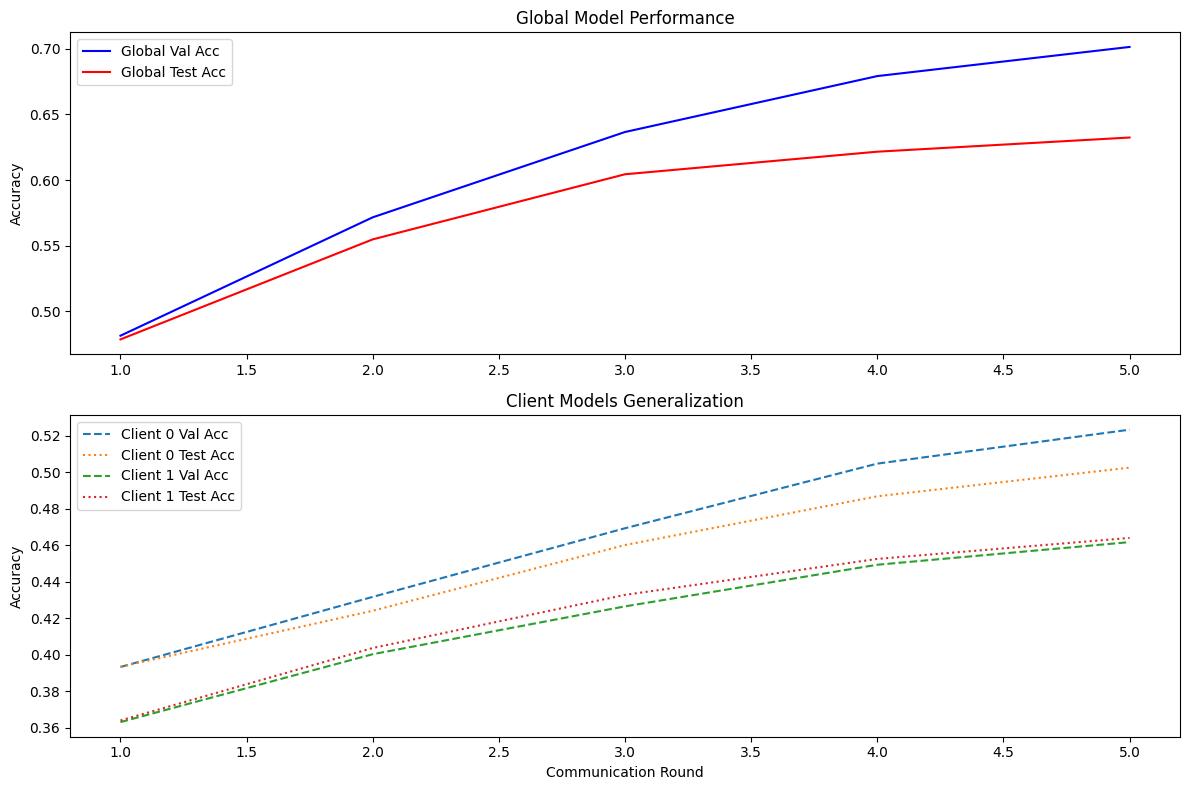

Training complete!

Final Client Generalization Performance:
Client 0 - Final Server Val Acc: 0.5234, Final Test Acc: 0.5026
Client 1 - Final Server Val Acc: 0.4618, Final Test Acc: 0.4641


In [19]:
if __name__ == "__main__":
    global_model, client_models, val_losses, val_accuracies, test_accuracies, clients_val_accuracies, clients_test_accuracies = train_bidirectional_fedkd()
    print("Training complete!")


---

# Knowledge Carrier: Logit Based

## Why **FedICT** Is a Suitable Baseline for Benchmarking

FedICT represents an ideal baseline as it uses logits-only knowledge transfer without sharing raw data, employing similarity-based aggregation to handle heterogeneous distributions. It applies adaptive weighting to balance client contributions based on their data characteristics, addressing similar non-IID challenges as our approach. FedICT's knowledge flow provides a clear comparison point against our bidirectional method, while its content-agnostic aggregation also is a robust technique. Additionally, its established performance on standard federated learning benchmarks offers a recognized reference point for evaluating our curriculum-based temperature adaptation strategy.


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Subset, random_split
from collections import Counter
import random

# Configuration
K = 2  # number of clients 
ALPHA = 0.5 # Dirichlet skew
CLIENT_SPLIT = 0.8 # train/test split per client
ROUNDS = 5
BATCH_SIZE = 64
LR = 1e-2
BETA = 2.0 # distillation temperature
LAMBDA = 0.1 # KD weight (start small)
DEVICE = torch.device('cuda')

# ------------------------------------------
# MODEL DEFINITION
# ------------------------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4,512), nn.ReLU(), nn.Dropout(0.25),
            nn.Linear(512,10)
        )
    def forward(self, x): return self.fc(self.conv(x))

# ------------------------------------------
# DATA PARTITIONING 
# ------------------------------------------
def load_and_partition_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)

    full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    n_total = len(full_dataset)
    n_server_val = int(0.1 * n_total)
    n_client_data = n_total - n_server_val

    g = torch.Generator().manual_seed(42)
    client_data, server_val_data = random_split(full_dataset, [n_client_data, n_server_val], generator=g)

    client_indices = client_data.indices
    all_targets = np.array(full_dataset.targets)
    labels = all_targets[client_indices]

    num_classes = 10
    num_clients = K

    np.random.seed(42)
    client_label_distribution = np.random.dirichlet(np.repeat(ALPHA, num_clients), size=num_classes)

    class_indices = [np.where(labels == class_idx)[0] for class_idx in range(num_classes)]

    client_indices = [[] for _ in range(num_clients)]
    for class_idx, distribution in enumerate(client_label_distribution):
        class_size = len(class_indices[class_idx])
        num_samples_per_client = (distribution * class_size).astype(int)
        samples_assigned = 0
        for client_idx, num_samples in enumerate(num_samples_per_client):
            if client_idx == num_clients - 1:
                num_samples = class_size - samples_assigned
            if num_samples > 0:
                selected_indices = class_indices[class_idx][samples_assigned:samples_assigned+num_samples]
                client_indices[client_idx].extend(selected_indices)
                samples_assigned += num_samples

    client_train_loaders = []
    client_val_loaders = []
    client_class_distributions = []
    for client_idx, indices in enumerate(client_indices):
        np.random.seed(42 + client_idx)
        np.random.shuffle(indices)

        client_labels = [labels[i] for i in indices]
        class_counts = Counter(client_labels)
        freqs = np.array([class_counts.get(c, 0) for c in range(10)], dtype=np.float32)
        d_k = freqs / freqs.sum()
        client_class_distributions.append(d_k)

        n_train = int(0.8 * len(indices))
        train_indices = indices[:n_train]
        val_indices = indices[n_train:]

        train_indices_original = [client_data.indices[i] for i in train_indices]
        val_indices_original = [client_data.indices[i] for i in val_indices]

        client_train_dataset = Subset(full_dataset, train_indices_original)
        client_val_dataset = Subset(full_dataset, val_indices_original)

        g_train = torch.Generator().manual_seed(42 + client_idx)
        g_val = torch.Generator().manual_seed(42 + client_idx + num_clients)

        train_loader = DataLoader(client_train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=g_train)
        val_loader = DataLoader(client_val_dataset, batch_size=BATCH_SIZE, generator=g_val)

        client_train_loaders.append(train_loader)
        client_val_loaders.append(val_loader)

    g_server = torch.Generator().manual_seed(42 + 2*num_clients)
    g_test = torch.Generator().manual_seed(42 + 2*num_clients + 1)

    server_val_loader = DataLoader(server_val_data, batch_size=BATCH_SIZE, generator=g_server)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, generator=g_test)

    return client_train_loaders, client_val_loaders, server_val_loader, test_loader, client_class_distributions

# ------------------------------------------
# ACCURACY FUNCTION
# ------------------------------------------
def accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred = model(x).argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total

# ------------------------------------------
# INIT: DATA + CLIENTS + PROXY
# ------------------------------------------
train_loaders, val_loaders, server_val_loader, test_loader, client_distributions = load_and_partition_data()

clients = []
for i in range(K):
    model = SimpleCNN().to(DEVICE)
    opt = optim.SGD(model.parameters(), LR, weight_decay=5e-4)
    clients.append({
        'model': model,
        'opt': opt,
        'train': train_loaders[i],
        'val': val_loaders[i],
        'd_k': client_distributions[i]
    })

proxy_loader = test_loader

# compute global distribution d_S
all_dk = np.stack([c['d_k'] for c in clients])
counts = np.array([len(c['train'].dataset) + len(c['val'].dataset) for c in clients])
d_S = (all_dk * counts[:, None]).sum(0)
d_S /= d_S.sum()

# ------------------------------------------
# TRAINING LOOP
# ------------------------------------------
for rnd in range(1, ROUNDS + 1):
    # 1. clients send logits on proxy
    client_logits = []
    for c in clients:
        c['model'].eval()
        out = []
        for x, _ in proxy_loader:
            with torch.no_grad():
                out.append(c['model'](x.to(DEVICE)).cpu())
        client_logits.append(torch.cat(out, dim=0))

    # 2. similarity weights
    sim_w = []
    for c in clients:
        sim = (d_S @ c['d_k']) / (np.linalg.norm(d_S) * np.linalg.norm(c['d_k']) + 1e-8)
        sim_w.append(sim)
    sim_w = np.array(sim_w)
    sim_w /= sim_w.sum()

    #NOTE: my z_S(x) = a weighted aggregation of all client logits on the proxy dataset (e.g., CIFAR-10 test set), used as a teacher for distillation.
    # 3. aggregate z_S
    stacked = torch.stack(client_logits)
    z_S = sum(sim_w[k] * stacked[k] for k in range(K))
    zS_batches = list(torch.split(z_S, BATCH_SIZE))

    # 4. client updates
    for k, c in enumerate(clients):
        m, o = c['model'], c['opt']
        m.train()

        for x, y in c['train']:
            x, y = x.to(DEVICE), y.to(DEVICE)
            o.zero_grad()
            F.cross_entropy(m(x), y).backward()
            o.step()

        for (x_p, _), zS_b in zip(proxy_loader, zS_batches):
            x_p = x_p.to(DEVICE)
            zS_b = zS_b.to(DEVICE)
            o.zero_grad()
            student_logits = m(x_p)
            student_logp = F.log_softmax(student_logits / BETA, dim=1)
            teacher_prob = F.softmax(zS_b / BETA, dim=1)
            loss_kd = F.kl_div(student_logp, teacher_prob, reduction='batchmean') * (BETA ** 2)
            (LAMBDA * loss_kd).backward()
            o.step()

    # 5. eval (showing on just 1 client)
    ua = 100 * np.mean([accuracy(c['model'], c['val']) for c in clients])
    sv = 100 * accuracy(clients[0]['model'], server_val_loader)
    gt = 100 * accuracy(clients[0]['model'], test_loader)

    print(f"Round {rnd:02d}: UA={ua:.2f}% | Server Val={sv:.2f}% | Global Test={gt:.2f}%")


Files already downloaded and verified
Files already downloaded and verified
Round 01: UA=42.57% | Server Val=23.76% | Global Test=23.57%
Round 02: UA=43.81% | Server Val=29.06% | Global Test=28.85%
Round 03: UA=45.81% | Server Val=33.14% | Global Test=32.82%
Round 04: UA=47.35% | Server Val=35.38% | Global Test=36.61%
Round 05: UA=49.68% | Server Val=39.74% | Global Test=40.90%


The results show that client models (UA) are steadily improving by learning from their own data and distilling global knowledge. Server validation and global test accuracy are also rising, indicating effective generalization across clients. This suggests that FedICT is successfully aligning local and global knowledge through logits-based distillation.

---

# **Moving Forward**

## Baselines vs. Our Proposed Methods

In this project, we've implemented innovative approaches for enhancing Federated Learning through knowledge distillation:

Our curriculum-based approach dynamically adjusts knowledge transfer based on client-server divergence, using heterogeneity scores/entropy/measures of randomness to determine optimal distillation parameters (temperature adaptive) as training progresses through communication rounds. This allows for more efficient knowledge transfer that adapts to each client's unique data characteristics and learning progress. Additionally, we aim to implement selective knowledge transfer mechanisms that intelligently mask less confident or irrelevant logit components based on adaptive thresholds that evolve throughout the training process. This allows for more efficient knowledge transfer that adapts to each client's unique data characteristics and learning progress. These evaluations will demonstrate how our framework addresses the fundamental challenges of federated learning in heterogeneous environments, leveraging both model parameters and logits as knowledge carriers (eventually we would transition to one based on the baseline models that we choose to incorporate in our ablation studies, but we are investigating both)

---

For our next deliverable, we'll perform comprehensive benchmarking against established baselines:


* FedAvg: The standard federated learning approach that performs weighted averaging of model parameters, serving as our primary baseline for comparison.

* FedICT: A more recent technique that incorporates clients’ fitting of local data by introducing prior knowledge of local data distributions, offering improved convergence properties over vanilla FedAvg.

* We might test out some other baselines as well, depending on knowledge carriers chosen and adaptability of the models into our non-IID partitioning pipeline (couple of baselines in mind: **FedDKC, FedGKT**)


We'll evaluate all approaches across multiple metrics including:


* Model performance under various heterogeneity conditions ((controlled via Dirichlet α parameter)
* Privacy preservation capabilities
* Might extend the framework to include further metrics such as UA values, testing performance across multiple architectures (FedICT, Zhiyuan Wu et al.)
